### Semi-supervised classification with Autoencoders

 In this kernel, is explained how to perform the classification task using a semi-supervised learning approach. This approach uses Autoencoders to learn the data representation, then a simple linear classifier is trained to classify the dataset into respective classes.The code is based on: https://www.kaggle.com/shivamb/

#### Bank fraud detection using semi-supervised learning


Dataset used [Credit Card Fraud Detection] (https://www.kaggle.com/mlg-ulb/creditcardfraud) 

#### Content

1. Dataset Preparation  
2. Visualize Fraud Vs Non Fraud Transactions  
3. AutoEncoders : Latent Representation Extraction  
4. Obtain the Latent Representations  
5. Visualize Latent Representations : Fraud vs Non Fraud  
6. Simple Linear Classifier  
7. Applying the same technique on Titanic Dataset


##### Process
1. train, test split
2. X_train, y_train -> scale.fit_transfor -> train autoencoder -> train linear classifier
3. X_test, y_test -> scale.transform -> run through autoencoder with learned weights -> apply linear classifier

In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(42)

In [2]:
data = pd.read_csv("data/creditcard.csv.zip")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percentage'] = vc['Class'].apply(lambda x : round(100*float(x)/len(data), 2))
vc = vc.rename(columns= {'index' : 'Target', 'Class' : 'Count'})
vc

,Target,Count,percentage
0,0,284315,99.83
1,1,492,0.17


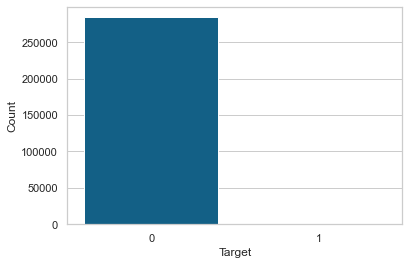

In [4]:
ax = sns.barplot(x='Target', y='Count', data=vc, color='#006699')

One of the biggest challenges of this problem is that the **objective is very imbalanced** as only **0.17%** of the cases are fraudulent transactions. But the advantage of the representation learning approach is that it is still able to handle such class imbalance. For our use case, let's take only about 1000 rows of fraud-free transactions.

In [10]:
non_fraud = data[data['Class'] == 0].sample(4000)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
#df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

In [11]:
X = df.drop(['Class'], axis=1).values
y = df['Class'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Visualize Fraud Vs Non Fraud Transactions

Let us visualize the nature of fraudulent and non-fraudulent transactions using T-SNE. T-SNE is a data dimensionality reduction technique and produces only the n principal components with maximum information.

Each point below represents one transaction. Non-fraudulent transactions are represented in blue, while fraudulent transactions are represented in orange. The two axes are the components extracted by tsne.

/Users/ftadeu/projects/autoencoders-rare-events/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ftadeu/projects/autoencoders-rare-events/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


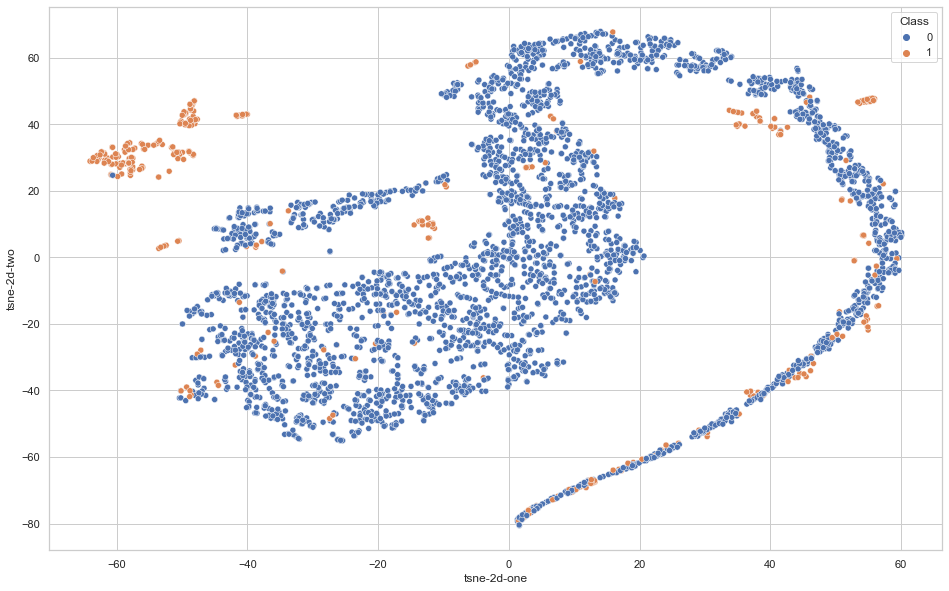

In [13]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results  = tsne.fit_transform(X_train)

train = pd.DataFrame()
train['Class'] = y_train
train['tsne-2d-one'] = tsne_results[:,0]
train['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Class",
    data=train,
    legend="full"
)


plt.savefig('original-data.png') 

#### Arquitetura do autoencoder

In [14]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)


autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

2022-07-24 16:04:20.770682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 16:04:20.771435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [15]:
from sklearn.preprocessing import StandardScaler

sc = preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)


X_train_norm, X_train_fraud = X_train[y_train == 0], X_train[y_train == 1]
X_test_norm, X_test_fraud = X_test[y_test == 0], X_test[y_test == 1]

In [16]:
autoencoder.fit(X_train_norm, X_train_norm, 
                batch_size = 256, epochs = 10, 
                validation_data=(X_test_norm, X_test_norm));

Epoch 1/10


2022-07-24 16:05:09.731936: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 16:05:10.049077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 20ms/step - loss: 0.2086 - val_loss: 0.1520
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 0.1477 - val_loss: 0.1445
Epoch 3/10
 1/13 [=>............................] - ETA: 0s - loss: 0.1445

2022-07-24 16:05:12.136103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 8ms/step - loss: 0.1423 - val_loss: 0.1413
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 0.1407 - val_loss: 0.1403
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 0.1399 - val_loss: 0.1396
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 0.1394 - val_loss: 0.1392
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 0.1389 - val_loss: 0.1387
Epoch 8/10
13/13 [==============================] - 0s 7ms/step - loss: 0.1385 - val_loss: 0.1383
Epoch 9/10
13/13 [==============================] - 0s 8ms/step - loss: 0.1381 - val_loss: 0.1380
Epoch 10/10
13/13 [==============================] - 0s 8ms/step - loss: 0.1378 - val_loss: 0.1377


We do not need too many data samples to learn good representations. We will use **only 2000 rows** of fraud-free cases to train the automatic coder. Also, we do not need to run this model for a large number of epochs.

**Explanation:** The choice of small samples from the original data set is based on the intuition that the features of one class (no fraud) will differ from those of the other (fraud). To distinguish these features, we need to show the automatic coders only one class of data. This is because the automatic coder will try to learn only one class and automatically distinguish the other class.

#### 4. Obtain the Latent Representations  

Now, the model is trained. We are interested in obtaining the **latent representation of the input** learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and only add the trained weights up to the third layer where the latent representation exists.

In [17]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes: non-fraud and fraud by predicting the raw entries using the above model.

In [18]:
X_train_hid_rep = hidden_representation.predict(X_train)
X_test_hid_rep = hidden_representation.predict(X_test)

 79/113 [===================>..........] - ETA: 0s

2022-07-24 17:20:40.777275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 5ms/step


### 5. Visualize the latent representations : Fraud Vs Non Fraud

Now we will create a training dataset using the latent representations obtained and let's visualize the nature of fraud vs non-fraud cases. 

In [19]:
norm_hid_rep = hidden_representation.predict(X_train_norm)
fraud_hid_rep = hidden_representation.predict(X_train_fraud)

13/13 [==============================] - 0s 23ms/step


In [20]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)

y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
rep_x = pd.DataFrame(rep_x)
rep_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.123801,0.0,0.0,0.131397,0.0,0.0,0.183299,0.167075,0.000000,0.0,0.0,0.944854,0.0,0.0,0.0,0.0,0.0,0.306864,0.278621,0.0,0.148870,0.983916,0.215980,0.0,0.721194,0.383242,0.901474,0.566901,0.0,0.374896,0.0,0.0,0.354172,0.0,0.0,0.209390,0.0,0.0,0.0,0.412122,0.000000,0.0,0.115354,0.0,0.0,0.867257,0.051324,0.0
1,0.0,0.0,0.214450,0.0,0.0,0.060954,0.0,0.0,0.292478,0.136558,0.000000,0.0,0.0,1.003605,0.0,0.0,0.0,0.0,0.0,0.365758,0.520341,0.0,0.218685,0.884618,0.597115,0.0,0.669073,0.271696,0.847779,0.579434,0.0,0.395311,0.0,0.0,0.256475,0.0,0.0,0.144649,0.0,0.0,0.0,0.515884,0.000000,0.0,0.196434,0.0,0.0,0.949554,0.046237,0.0
2,0.0,0.0,0.091723,0.0,0.0,0.184089,0.0,0.0,0.142299,0.251794,0.000000,0.0,0.0,0.955652,0.0,0.0,0.0,0.0,0.0,0.306050,0.206155,0.0,0.220731,1.006084,0.249963,0.0,0.785428,0.532197,0.871604,0.529046,0.0,0.394089,0.0,0.0,0.304721,0.0,0.0,0.218876,0.0,0.0,0.0,0.484219,0.000000,0.0,0.069585,0.0,0.0,0.825609,0.054283,0.0
3,0.0,0.0,0.000905,0.0,0.0,0.240293,0.0,0.0,0.112445,0.316011,0.056642,0.0,0.0,1.028446,0.0,0.0,0.0,0.0,0.0,0.424987,0.123231,0.0,0.473128,1.142701,0.148003,0.0,0.733346,0.481972,0.858207,0.513178,0.0,0.405360,0.0,0.0,0.267361,0.0,0.0,0.251384,0.0,0.0,0.0,0.479820,0.000000,0.0,0.001198,0.0,0.0,0.768988,0.032343,0.0
4,0.0,0.0,0.055017,0.0,0.0,0.218110,0.0,0.0,0.080169,0.295598,0.000000,0.0,0.0,0.977761,0.0,0.0,0.0,0.0,0.0,0.363651,0.090443,0.0,0.272912,1.055169,0.177174,0.0,0.806866,0.576210,0.882724,0.504608,0.0,0.440709,0.0,0.0,0.229535,0.0,0.0,0.238210,0.0,0.0,0.0,0.460772,0.000000,0.0,0.057057,0.0,0.0,0.826823,0.080731,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588,0.0,0.0,0.000000,0.0,0.0,0.215830,0.0,0.0,0.003080,0.328504,0.000000,0.0,0.0,0.875157,0.0,0.0,0.0,0.0,0.0,0.411996,0.000000,0.0,0.352189,1.052700,0.000000,0.0,0.773298,0.351756,0.916348,0.609889,0.0,0.303555,0.0,0.0,0.073857,0.0,0.0,0.295448,0.0,0.0,0.0,0.457707,0.000000,0.0,0.070926,0.0,0.0,0.833909,0.129629,0.0
3589,0.0,0.0,0.115791,0.0,0.0,0.032197,0.0,0.0,0.281239,0.097984,0.000000,0.0,0.0,0.862092,0.0,0.0,0.0,0.0,0.0,0.214562,0.498188,0.0,0.088171,0.775942,0.350816,0.0,0.405774,0.023238,0.882346,0.682886,0.0,0.248955,0.0,0.0,0.326611,0.0,0.0,0.000000,0.0,0.0,0.0,0.439205,0.022663,0.0,0.175556,0.0,0.0,1.031748,0.155020,0.0
3590,0.0,0.0,0.060072,0.0,0.0,0.173130,0.0,0.0,0.121286,0.257210,0.000000,0.0,0.0,0.921871,0.0,0.0,0.0,0.0,0.0,0.294797,0.242974,0.0,0.097231,0.929625,0.256412,0.0,0.570295,0.307421,0.840697,0.550436,0.0,0.334467,0.0,0.0,0.312568,0.0,0.0,0.126732,0.0,0.0,0.0,0.404289,0.000000,0.0,0.094381,0.0,0.0,0.914236,0.142944,0.0
3591,0.0,0.0,0.000000,0.0,0.0,0.162786,0.0,0.0,0.000000,0.182719,0.000000,0.0,0.0,0.779187,0.0,0.0,0.0,0.0,0.0,0.249293,0.095013,0.0,0.081465,0.910257,0.000000,0.0,0.472432,0.296658,0.807059,0.505339,0.0,0.286230,0.0,0.0,0.215313,0.0,0.0,0.044497,0.0,0.0,0.0,0.340305,0.000000,0.0,0.063553,0.0,0.0,0.856975,0.137371,0.0


/Users/ftadeu/projects/autoencoders-rare-events/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ftadeu/projects/autoencoders-rare-events/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


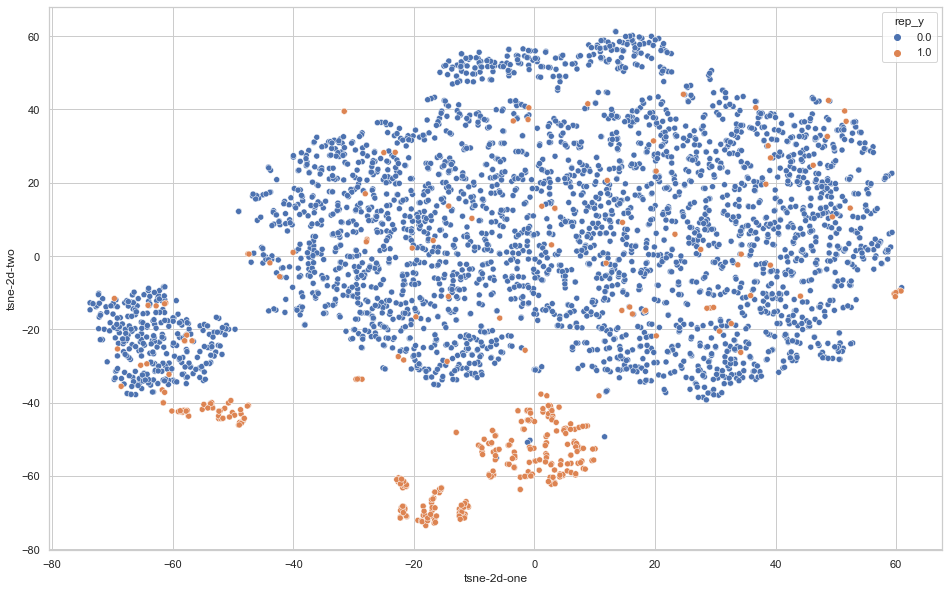

In [21]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results  = tsne.fit_transform(rep_x)

rep_x['tsne-2d-one'] = tsne_results[:,0]
rep_x['tsne-2d-two'] = tsne_results[:,1]
rep_x['rep_y'] = rep_y

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="rep_y",
    data=rep_x,
    legend="full"
)


plt.savefig('autoencoder_data.png') 

We can observe that now fraudulent and non-fraudulent transactions are quite visible and linearly separable. Now we do not need any complex model to classify this, even the simplest models can be used to predict. Here is the before and after view of fraudulent and non-fraudulent transactions.

In [22]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original-data.png'></td><td>
             <img src='autoencoder_data.png'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


#### 6. Simple Linear Classifier

In [24]:
clf = LogisticRegression(solver="lbfgs").fit(X_train_hid_rep, y_train)
pred_y = clf.predict(X_test_hid_rep)

In [25]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, pred_y))


Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       806
           1       0.98      0.66      0.79        93

    accuracy                           0.96       899
   macro avg       0.97      0.83      0.88       899
weighted avg       0.96      0.96      0.96       899


Accuracy Score:  0.9632925472747497


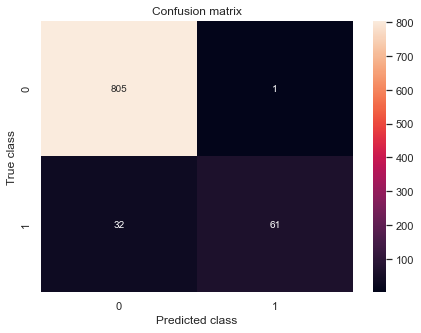

In [26]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

conf_matrix = confusion_matrix(y_test, pred_y)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix,  annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()